In [4]:
import os
os.chdir("..")
os.getcwd()


'/Users/lucasnseyep/code/LucasNseyep/safesurf/crypto-bot'

In [15]:
from src.core.data_reader import load_ohlcv
from src.core.momentum import add_momentum_signal
from src.core.backtest import run_backtest

df = load_ohlcv(
    root="data",
    exchange="binance",
    symbol="BTC/USDT",
    timeframe="1h",
    start="2024-01-01",
    end="2024-04-01",
)

df.head()

,timestamp,open,high,low,close,volume,datetime
0,1704067200000,42283.58,42554.57,42261.02,42475.23,1271.68108,2024-01-01 00:00:00+00:00
1,1704070800000,42475.23,42775.00,42431.65,42613.56,1196.37856,2024-01-01 01:00:00+00:00
2,1704074400000,42613.57,42638.41,42500.00,42581.10,685.21980,2024-01-01 02:00:00+00:00
3,1704078000000,42581.09,42586.64,42230.08,42330.49,794.80391,2024-01-01 03:00:00+00:00
4,1704081600000,42330.50,42399.99,42209.46,42399.99,715.41760,2024-01-01 04:00:00+00:00


In [ ]:
# import pandas as pd

# def add_momentum_signal(df, fast=20, slow=50):
#     df = df.copy()
#     df["sma_fast"] = df["close"].rolling(fast).mean()
#     df["sma_slow"] = df["close"].rolling(slow).mean()

#     # signal: +1 long, 0 flat (you can also do -1 short if you want)
#     df["signal_raw"] = 0
#     df.loc[df["sma_fast"] > df["sma_slow"], "signal_raw"] = 1
#     df.loc[df["sma_fast"] < df["sma_slow"], "signal_raw"] = -1

#     return df


In [ ]:
# def run_backtest(df, fee_bp=5):
#     df = df.copy()

#     # 1. create returns - returns defined as a percentage difference from yesterday's close
#     df["ret"] = df["close"].pct_change().fillna(0)

#     # 2. use signal from previous bar to trade this bar - based on the momentum that we found at the previous row, we'll trade today's row or not
#     df["position"] = df["signal_raw"].shift(1).fillna(0) # TO REVIEW

#     # 3. gross strategy return
#     df["strategy_ret_gross"] = df["position"] * df["ret"]

#     # 4. simple cost model: pay fee when position changes - when the momentum changes from -1, 1, 0 to something else, you will need to make a trade and incur fees because of that
#     df["trade"] = df["position"].diff().abs().fillna(abs(df["position"].iloc[0])) # TO REVIEW
#     cost_per_trade = fee_bp / 1e4
#     df["cost"] = df["trade"] * cost_per_trade

#     df["strategy_ret_net"] = df["strategy_ret_gross"] - df["cost"]

#     # 5. equity curve (starting at 1.0)
#     df["equity"] = (1 + df["strategy_ret_net"]).cumprod()

#     return df


In [16]:
# print(df)

df_sig = add_momentum_signal(df)

print(df_sig.iloc[48:58])

bt = run_backtest(df_sig)

print("Final equity:", bt["equity"].iloc[-1])
print("Total return:", bt["equity"].iloc[-1] - 1)

# Annualized-ish metrics (rough)
import numpy as np
daily_ret = bt.resample("1D", on="datetime")["strategy_ret_net"].sum()
# print(daily_ret)
sharpe = np.sqrt(252) * daily_ret.mean() / daily_ret.std()
print("Sharpe (approx):", sharpe)


        timestamp      open      high       low     close      volume  \
48  1704240000000  44946.91  45212.57  44862.11  45135.61  1410.31904   
49  1704243600000  45135.61  45329.83  45102.72  45317.58  1166.18095   
50  1704247200000  45317.58  45410.91  45211.73  45274.57  1434.81631   
51  1704250800000  45274.57  45310.00  45151.91  45262.69   739.36966   
52  1704254400000  45262.70  45272.16  45115.59  45183.45   796.78600   
53  1704258000000  45183.45  45294.11  45118.91  45172.13   849.38832   
54  1704261600000  45172.12  45363.19  45160.00  45326.93  1264.55564   
55  1704265200000  45326.92  45384.84  44940.93  45011.77  1780.38521   
56  1704268800000  45011.77  45200.00  45001.10  45200.00  1462.95207   
57  1704272400000  45200.00  45500.00  45185.39  45344.67  2006.28796   

                    datetime    sma_fast    sma_slow  signal_raw  
48 2024-01-03 00:00:00+00:00  45256.4715         NaN           0  
49 2024-01-03 01:00:00+00:00  45263.3765  44087.3464          

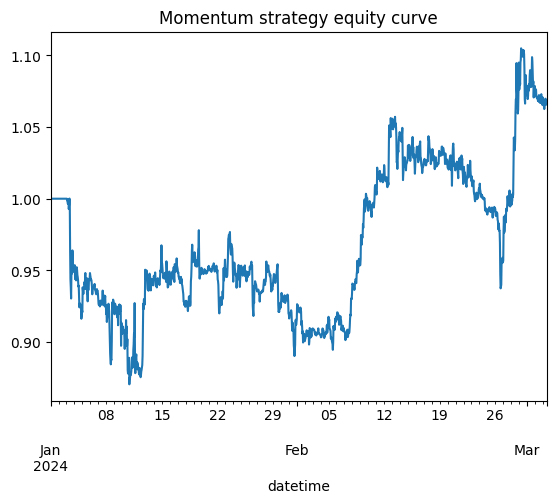

In [17]:
import matplotlib.pyplot as plt

bt.set_index("datetime")["equity"].plot()
plt.title("Momentum strategy equity curve")
plt.show()